# Loading and Exploring Data

In [2]:
import pandas as pd

# Load the dataset
file_path = 'customer_churn_dataset-training-master.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Explore the dataset
print("Dataset Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None

First 5 Rows:
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0          

# Data Cleaning

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Drop rows with missing critical values
df.dropna(subset=['CustomerID', 'Last Interaction', 'Total Spend'], inplace=True)

# Convert necessary columns to correct data types
df['Payment Delay'] = pd.to_numeric(df['Payment Delay'], errors='coerce')
df['Last Interaction'] = pd.to_datetime(df['Last Interaction'], errors='coerce')

# Drop rows where conversions failed
df.dropna(inplace=True)


Missing Values:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


# Feature Engineering

In [5]:
from datetime import datetime

# Calculate 'Days Since Last Interaction'
current_date = datetime.now()
df['Days Since Last Interaction'] = (current_date - df['Last Interaction']).dt.days

# Calculate churn rate
churn_rate = df['Churn'].value_counts(normalize=True)[1.0] * 100

# Calculate average spend per customer
average_spend = df['Total Spend'].mean()

# Revenue loss from churned customers
revenue_loss = df[df['Churn'] == 1.0]['Total Spend'].sum()

# Segment-based churn
churn_by_segment = df.groupby('Subscription Type')['Churn'].value_counts(normalize=True).unstack() * 100

print("Churn Rate:", churn_rate)
print("Average Spend:", average_spend)
print("Revenue Loss:", revenue_loss)
print("\nChurn by Segment:")
print(churn_by_segment)


Churn Rate: 56.710719729965156
Average Spend: 631.6162227787628
Revenue Loss: 135320840.60000002

Churn by Segment:
Churn                    0.0        1.0
Subscription Type                      
Basic              41.821767  58.178233
Premium            44.058300  55.941700
Standard           43.930047  56.069953


# Save Cleaned Data to a Database

In [6]:
from sqlalchemy import create_engine

# Create SQLite database engine
engine = create_engine('sqlite:///customer_churn.db')

# Save cleaned data to the database
df.to_sql('cleaned_customer_data', engine, if_exists='replace', index=False)

print("Data successfully saved to database.")


Data successfully saved to database.


# Visualization in Python

## Churn Rate Visualization

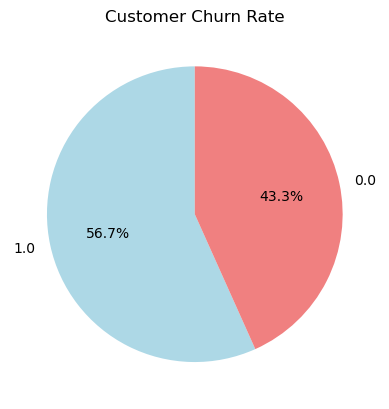

In [7]:
import matplotlib.pyplot as plt

# Churn Rate Pie Chart
churn_counts = df['Churn'].value_counts()
labels = churn_counts.index
sizes = churn_counts.values
colors = ['lightblue', 'lightcoral']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Customer Churn Rate')
plt.show()


## Churn by Segment (Bar Chart)

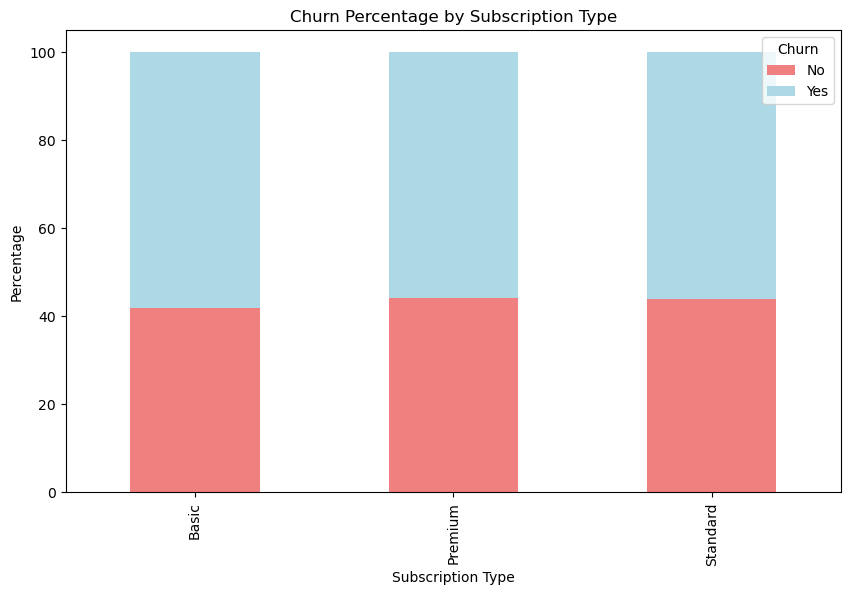

In [8]:
# Bar Chart for Churn by Subscription Type
import seaborn as sns

churn_segment_data = df.groupby('Subscription Type')['Churn'].value_counts(normalize=True).unstack() * 100
churn_segment_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightcoral', 'lightblue'])

plt.title('Churn Percentage by Subscription Type')
plt.ylabel('Percentage')
plt.xlabel('Subscription Type')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()


# Export to CSV for Dashboard Tools

In [9]:
# Export to CSV
output_path = 'cleaned_customer_data.csv'
df.to_csv(output_path, index=False)

print(f"Cleaned data exported to {output_path}")


Cleaned data exported to cleaned_customer_data.csv


# Churn Prediction (Using Logistic Regression)

## Prepare Data for Modeling

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])
df['Subscription Type'] = encoder.fit_transform(df['Subscription Type'])
df['Contract Length'] = encoder.fit_transform(df['Contract Length'])
df['Churn'] = encoder.fit_transform(df['Churn'])

# Select features and target
features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 
            'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend']
target = 'Churn'

X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Train Logistic Regression Model

In [15]:
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = LogisticRegression(max_iter=420)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8449073724007562

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     57160
           1       0.88      0.85      0.86     75090

    accuracy                           0.84    132250
   macro avg       0.84      0.84      0.84    132250
weighted avg       0.85      0.84      0.85    132250



# Incorporating Predictive Insights
## Predicting Churn Using the Logistic Regression Model
The goal is to integrate the churn prediction model into the dashboard. Use Python to generate predictions and add them to the dataset for visualization.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode categorical variables
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])
df['Subscription Type'] = encoder.fit_transform(df['Subscription Type'])
df['Contract Length'] = encoder.fit_transform(df['Contract Length'])
df['Churn'] = encoder.fit_transform(df['Churn'])

# Features and target
features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 
            'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend']
target = 'Churn'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=420)
model.fit(X_train, y_train)

# Add predictions to the dataset
df['Predicted Churn'] = model.predict(X)
df['Churn Probability'] = model.predict_proba(X)[:, 1]


In [17]:
# Save updated dataset
df.to_csv('customer_data_with_predictions.csv', index=False)
